# Análise de evasão de clientes bancários (churn)

In [79]:
# Importando bibliotecas
import warnings
# Para manipulação e visualização
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.offline as py
from plotly.subplots import make_subplots
# Para limpeza e padronização dos nomes das tabelas
import janitor 
# Para fazer a partição do dados 
from sklearn.model_selection import train_test_split
# Para feature engineering
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from feature_engine.encoding import OrdinalEncoder, OneHotEncoder
from feature_engine.outliers import Winsorizer 
from feature_engine.discretisation import EqualWidthDiscretiser
# Modelos preditivos 
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
# Para métricas do modelo
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report, PrecisionRecallDisplay
from yellowbrick.classifier import DiscriminationThreshold, PrecisionRecallCurve, ROCAUC
# Para oversampling
from imblearn.over_sampling import SMOTE
# Para validação Cruzada 
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score, average_precision_score
warnings.filterwarnings('ignore')

In [4]:
df = pd.read_csv("Customer-Churn-Records.csv").clean_names()

In [5]:
df.head()

rownumber  customerid   surname  creditscore geography  gender  age  \
0          1    15634602  Hargrave          619    France  Female   42   
1          2    15647311      Hill          608     Spain  Female   41   
2          3    15619304      Onio          502    France  Female   42   
3          4    15701354      Boni          699    France  Female   39   
4          5    15737888  Mitchell          850     Spain  Female   43   

   tenure    balance  numofproducts  hascrcard  isactivemember  \
0       2       0.00              1          1               1   
1       1   83807.86              1          0               1   
2       8  159660.80              3          1               0   
3       1       0.00              2          0               0   
4       2  125510.82              1          1               1   

   estimatedsalary  exited  complain  satisfaction_score card_type  \
0        101348.88       1         1                   2   DIAMOND   
1        112542.58       0         1                   3   DIAMOND   
2        113931.57       1         1                   3   DIAMOND   
3         93826.63       0         0                   5      GOLD   
4         79084.10       0         0                   5      GOLD   

   point_earned  
0           464  
1           456  
2           377  
3           350  
4           425

#### Esse dataset possui um número pequeno de observações de 10.000 clientes com 18 features, abrangendo suas características pessoais, produtos financeiros e histórico de atividade. Cada registro descreve um cliente e inclui se ele deixou ou não o banco (churn), sendo essa a variável de interesse da predição.

### Dentro desse projeto usarei a metodologia de projetos `CRISP-DM` (Cross-Industry Standard Process for Data Mining) tentando levar perguntas e suas respostas ao longo do processo.

# 1. Entendimento do Negócio

## 1- Qual é o problema de negócios que estamos tentando resolver?  
#### &ensp;&ensp; Predizer a evasão (churn) de clientes. É importante salientar que nem todo problema de churn é igual; alguns deles são mais claros como por exemplo o caso de subseções, porem outros como diminuição de gastos, ou compras sazonais em plaformas online são menos evidentes.  
#### &ensp;&ensp; Pense no caso de uma empresa que possui um ticket alto para seu produto, onde geralmente os clientes compram em intervalos médios de 6 meses a 1 ano, nesse caso um cliente que não compra a 5~8 meses fez o churn, ou apenas está dormente ?  
#### &ensp;&ensp; Ao mesmo tempo nem todo cliente tem a mesma importância, clientes que estão quase inativos mas de alto valor na margem de evadir o negócio/plataforma, assim como clientes que recém evadiram do negócios mas que possuem alto valor (representado na imagem) merecem mais atenção pois são mais propensos a aceitar campanhas de marketing ou cupons de desconto do que clientes considerados "causa perdidas", ao mesmo tempo a empresa não seja perder lucro como um cliente que já pagaria o valor todas de seus produto (como descontos por exemplo).  
#### &ensp;&ensp; Boas fonte para estudo do tema: 
#### &ensp;&ensp; (https://www.youtube.com/watch?v=w-EdpLz8m7g)
#### &ensp;&ensp;(https://stripe.com/en-br/resources/more/how-to-build-a-customer-churn-model-a-guide-for-businesses)
## 2- Quais são os objetivos de negócios e os critérios de sucesso?
#### &ensp; &ensp; Objetivo do negócio é a venda de produtos bancários (de todos os tipos), nesse projeto em específico tem a finalidade da criação de um modelo preditivo que possa antecipar a evasão de clientes para que medidas possam ser tomadas com antecedência (ou no momento mais próximo possível) por outras ramos da empresa (retomarei esses pontos na conclusão)  
#### &ensp; &ensp; Os critérios de sucesso serão Recall score e F1 Score, dado que são dados que possuímos casos de dados desbalanceados, métricas como acurácia por exemplo não seria adequado, também será utilizado um modelo baseline de regressão logística sem tuning (amplamente utilizado em casos de classificação)
    
## 3- Quais suposições estamos fazendo e quais são os riscos potenciais?  
#### &ensp; &ensp; As suposições serão melhores elencadas na parte 2 (Entendimento dos Dados), mas preventivamente espera-se que clientes inativos e com saldos em conta negativos tendam a evadir com mais frequência tornando essa features possíveis bons preditores  
    
## 4- Quais são as expectativas da empresa e as suas?
#### &ensp; &ensp; Criação de um modelo preditivo que supere o baseline determinado

# 2. Entendimento dos Dados

## 1- Que dados estão disponíveis para nós?
#### &ensp;&ensp; Esse dataset possui um número pequeno de observações de 10.000 clientes com 18 features, abrangendo suas características pessoais, produtos financeiros e histórico de atividade. Cada registro descreve um cliente e inclui se ele deixou ou não o banco (churn), sendo essa a variável de interesse da predição.
Variáveis:
- rownumber: Número da linha correspondente no conjunto de dados.
- customerid: Identificador único para o cliente.
- surname: Sobrenome do cliente.
- creditscore: Pontuação de crédito do cliente.
- geography: País onde o cliente reside.
- gender: Gênero do cliente.
- age: Idade do cliente.
- tenure: Número de anos que o cliente está com o banco.
- balance: Saldo atual da conta do cliente no banco.
- numofproducts: Número de produtos que o cliente tem com o banco (ex: conta corrente, poupança, cartão de crédito).
- hascrcard: Indica se o cliente possui um cartão de crédito com o banco (1 = sim, 0 = não).
- isactivemember: Indica se o cliente é um membro ativo (1 = sim, 0 = não).
- estimatedsalary: Salário estimado anual do cliente.
- exited: Indica se o cliente deixou o banco (1 = sim, 0 = não).
- complain: Indica se o cliente registrou alguma reclamação (1 = sim, 0 = não).
- satisfaction_score: Pontuação de satisfação do cliente, numa escala de 1 a 5.
- card_type: Tipo de cartão de crédito fornecido ao cliente (ex: DIAMOND, GOLD).
- point_earned: Pontos ganhos pelo cliente com base nas transações e atividades no banco.
## 2- Quais são as fontes de dados e como elas são coletadas?
#### &ensp;&ensp; [Kaggle](https://www.kaggle.com/datasets/radheshyamkollipara/bank-customer-churn/data)
## 3- Os dados disponíveis são suficientes para resolver o problema?
#### &ensp;&ensp; Sim
## 4- Existem problemas de qualidade de dados que precisamos endereçar?
#### &ensp;&ensp; Não o dataset parece bem consistente e limpo

In [6]:
# Para visualizar o nível de correlação da variáveis com nosso target
num_vari = [col for col in df.columns if df[col].dtype in ["int64", "float64"]]
correlation_matrix = df[num_vari].corr()
correlation_com_target = correlation_matrix['exited']
correlation_com_target

rownumber            -0.016140
customerid           -0.006203
creditscore          -0.026771
age                   0.285296
tenure               -0.013656
balance               0.118577
numofproducts        -0.047611
hascrcard            -0.006976
isactivemember       -0.156356
estimatedsalary       0.012490
exited                1.000000
complain              0.995693
satisfaction_score   -0.005849
point_earned         -0.004628
Name: exited, dtype: float64

- Aparentemente complain tem um correlação quase perfeita. Como o cliente pode ter feito a reclamação no momento de evasão ou até mesmo posterior a isso o melhor procedimento é retirar a variável.

In [7]:
# Função para facilitar a visualização numérica 
def dataoveriew(X_train_full, message):
    print(f'{message}:\n')
    print("Rows:", df.shape[0])
    print("\nNumber of features:", df.shape[1])
    print("\nFeatures:")
    print(df.columns.tolist())
    print("\nMissing values:", df.isnull().sum().values.sum())
    print("\nUnique values:")
    print(df.nunique())
    print("\nData types:")
    print(df.dtypes)

In [8]:
dataoveriew(df, 'Overiew of the dataset')

Overiew of the dataset:

Rows: 10000

Number of features: 18

Features:
['rownumber', 'customerid', 'surname', 'creditscore', 'geography', 'gender', 'age', 'tenure', 'balance', 'numofproducts', 'hascrcard', 'isactivemember', 'estimatedsalary', 'exited', 'complain', 'satisfaction_score', 'card_type', 'point_earned']

Missing values: 0

Unique values:
rownumber             10000
customerid            10000
surname                2932
creditscore             460
geography                 3
gender                    2
age                      70
tenure                   11
balance                6382
numofproducts             4
hascrcard                 2
isactivemember            2
estimatedsalary        9999
exited                    2
complain                  2
satisfaction_score        5
card_type                 4
point_earned            785
dtype: int64

Data types:
rownumber               int64
customerid              int64
surname                object
creditscore             int6

- É possível ver que algumas colunas já pode ser descartadas (rownumber, customerid, surname), pois não serão usadas na análise. Não existe valores vazios, logo não há a necessidade de realizar imputation.
Nenhum das variáveis categóricas apresenta altos números de cardinalidade, não parece haver nada de incomum com os types das variáveis.

In [9]:
# Eliminando variáveis que não serão utilizadas
df = df.drop(["rownumber", "customerid", "surname","complain"], axis= 1)

In [10]:
# Separação dos dados em treino e teste, nesse caso para evitar "data snooping" e vieses futuros
X_train_f, X_test, y_train_f, y_test = train_test_split(
    df.drop("exited", axis= 1), # Retirando o target
    df["exited"],
    test_size= 0.2, # 80/20
    random_state= 42) # para facilitar a reprodução
X_train_f.shape, X_test.shape

((8000, 13), (2000, 13))

In [11]:
X_train_f["exited"] = y_train_f
train_full = X_train_f.copy()
X_train_f = X_train_f.drop("exited", axis= 1)

## Análise Exploratória de Dados

In [12]:
labels = train_full["exited"].value_counts().keys().tolist()
values = train_full["exited"].value_counts().values.tolist()
min_part_index = values.index(min(values))
# Para visualizar o desbalanceamento das classes 
trace = go.Pie(labels=labels,
               values=values,
               marker=dict(colors=['blue', 'red'],  # Alteração das cores aqui
                           line=dict(color="white", width=1.3)),
               rotation=90,
               hoverinfo="label+value+text",
               hole=.5,
               pull=[0.05 if i == min_part_index else 0 for i in range(len(values))]  # Destaca a menor parte
              )

layout = go.Layout(dict(title="Evasão de Clientes",
                        plot_bgcolor="rgb(243,243,243)",
                        paper_bgcolor="rgb(243,243,243)"))

# Criar e plotar a figura
fig = go.Figure(data=[trace], layout=layout)
py.iplot(fig)

- Como já foi dito esse é um claro problema de classificação com dados desbalanceados

In [13]:
# Calcular a contagem de clientes por região geográfica e status de 'exited'
geography_exited_counts = pd.crosstab(train_full['geography'], train_full['exited'])
# Criar o gráfico de barras para cada status de 'exited'
trace0 = go.Bar(x=geography_exited_counts.index,
                y=geography_exited_counts[0],
                name='Permaneceu',
                marker=dict(color='blue'))

trace1 = go.Bar(x=geography_exited_counts.index,
                y=geography_exited_counts[1],
                name='Saiu',
                marker=dict(color='red'))

# Agrupar os dados em uma lista
data = [trace0, trace1]

# Configurar o layout do gráfico
layout = go.Layout(barmode='group',  # Modo agrupado
                   title=dict(text='Distribuição Geográfica dos Clientes por Status de Saída', x=0.5),
                   xaxis=dict(title='Região Geográfica'),
                   yaxis=dict(title='Contagem de Clientes'),
                   legend=dict(x=0.8, y=1.2))

# Criar e plotar a figura
fig = go.Figure(data=data, layout=layout)
py.iplot(fig)

- Apesar de possuir o dobra de observações dos outros 2 países a França tem o mesmo número de evasões que a Alemanha

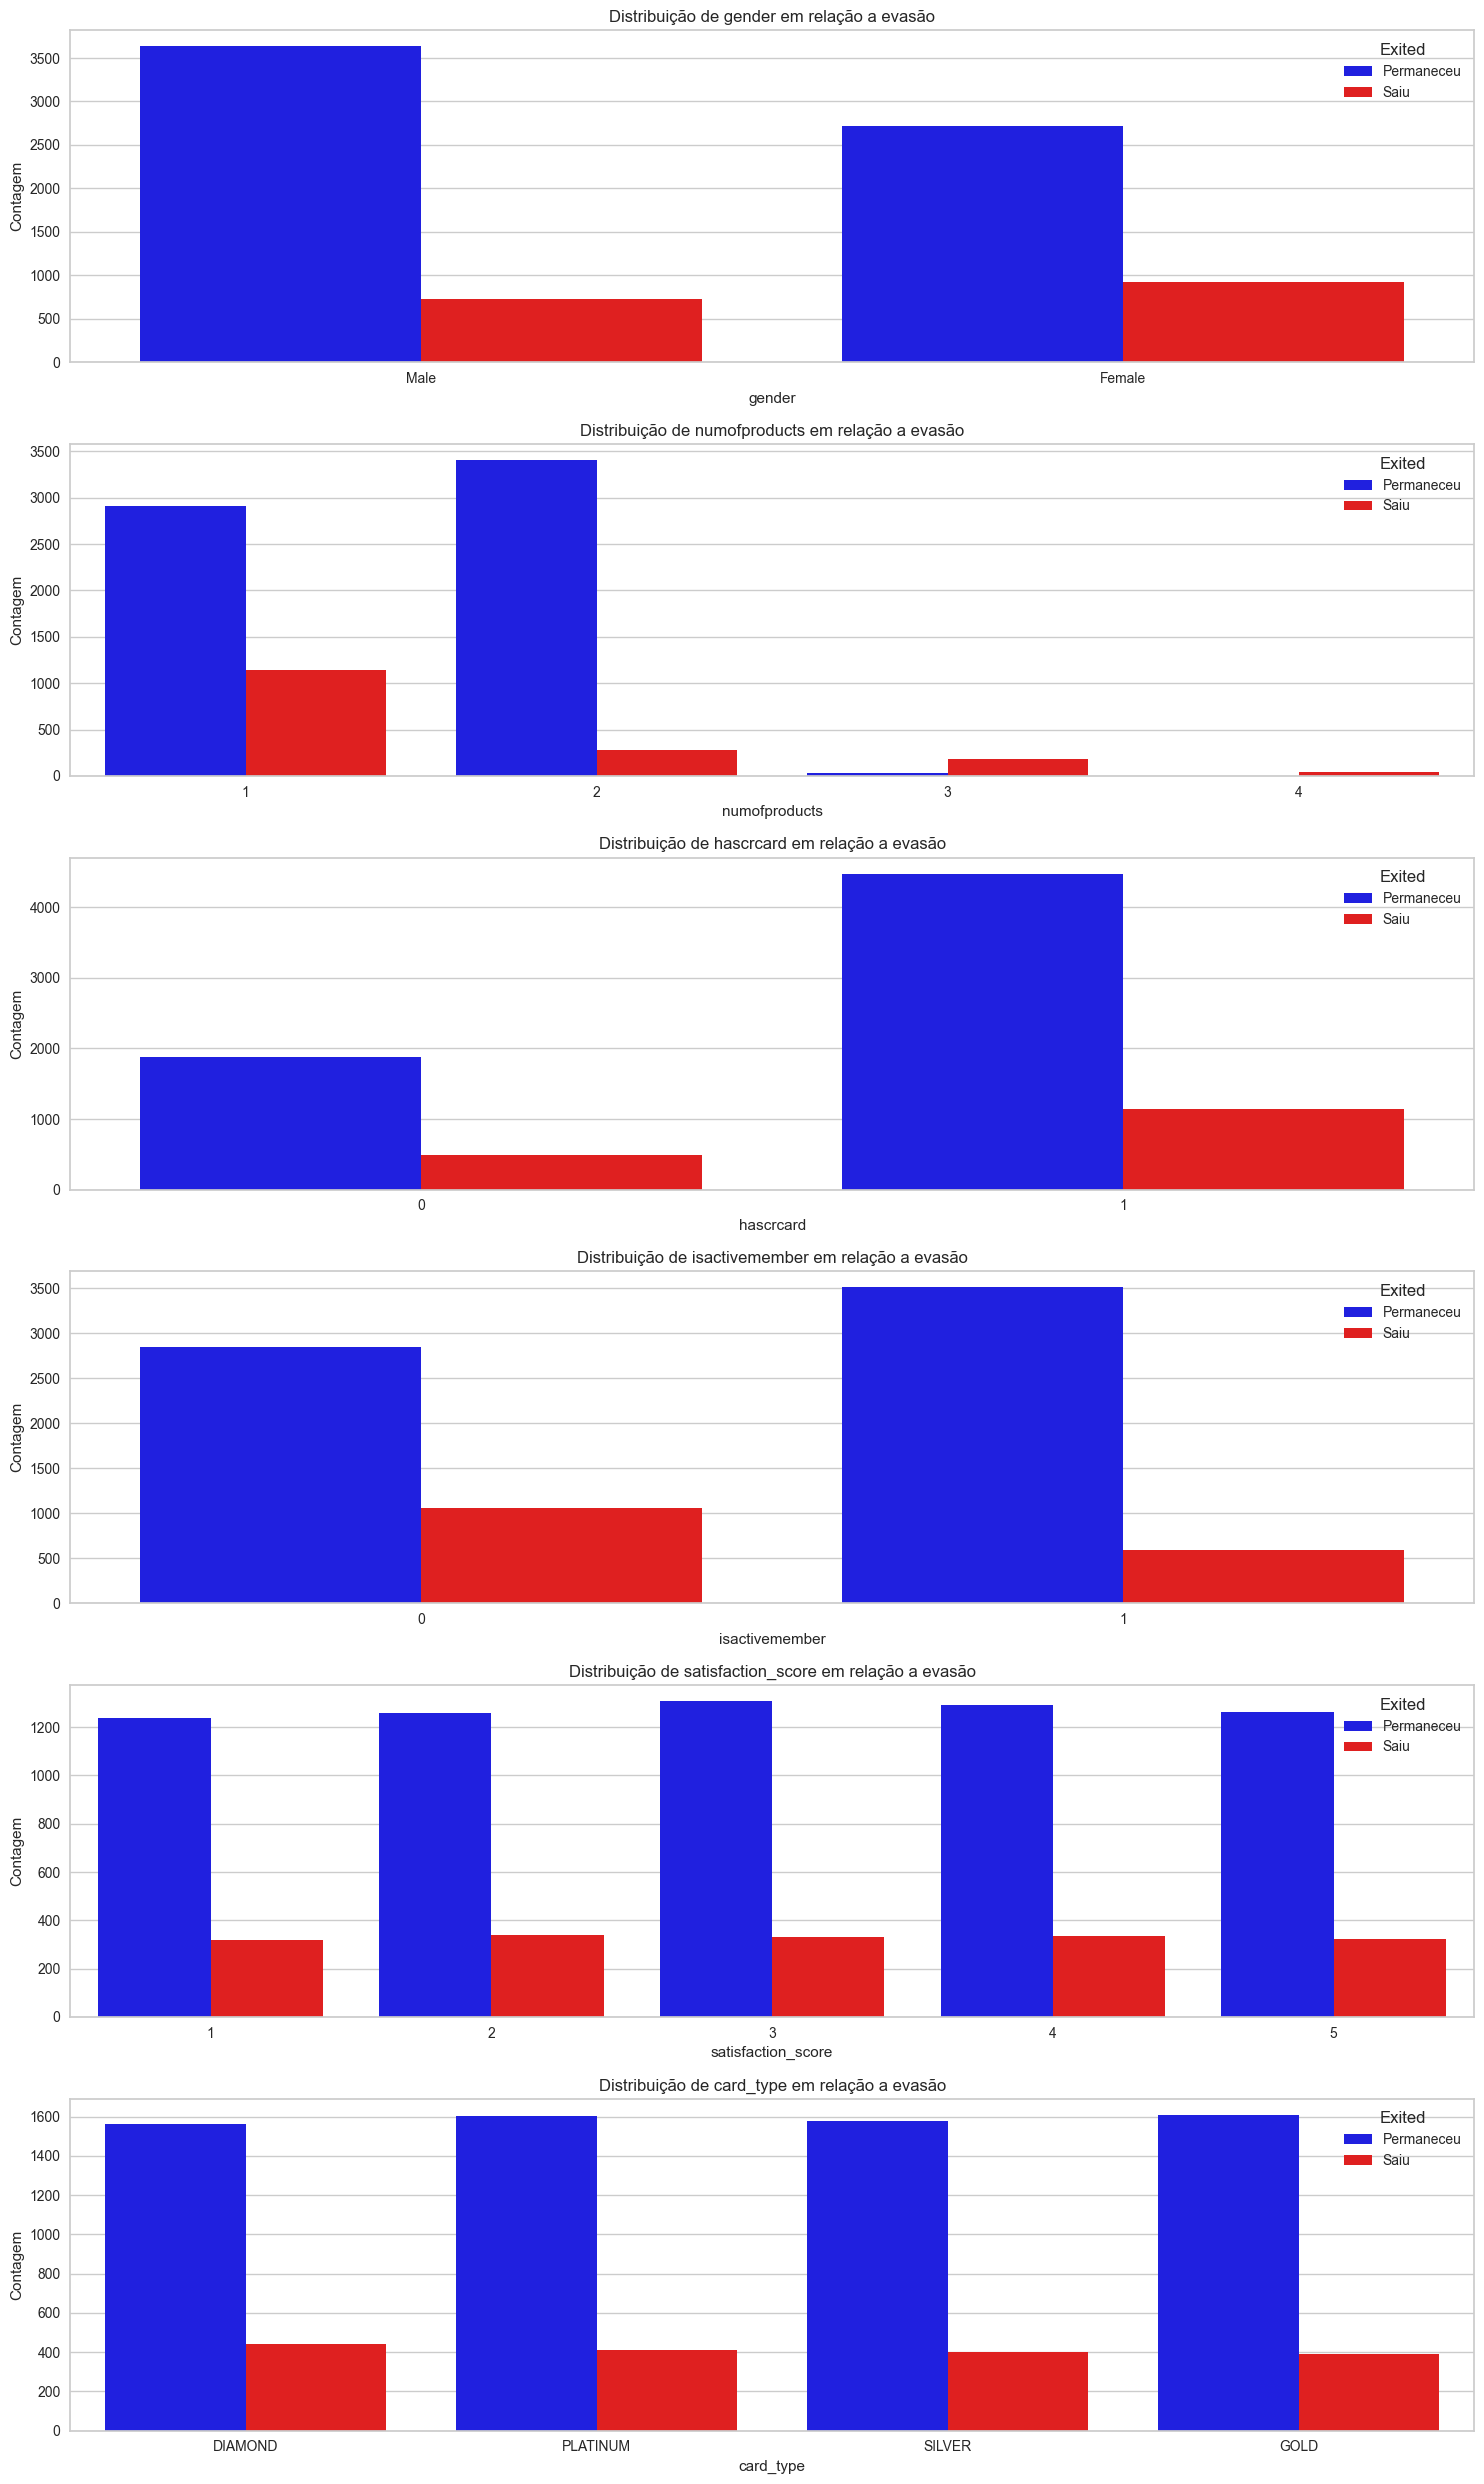

In [14]:
# Configuração do tamanho do gráfico
plt.figure(figsize=(15, 25))
columns_to_plot = ['gender', 'numofproducts', 'hascrcard', 'isactivemember', 'satisfaction_score', 'card_type']

# Definindo as cores para a legenda Exited
palette_colors = {0: 'blue', 1: 'red'}

# Loop para plotar cada variável
for i, col in enumerate(columns_to_plot):
    ax = plt.subplot(len(columns_to_plot), 1, i+1)
    sns.countplot(x=col, hue='exited', data=train_full, palette=palette_colors)
    plt.title(f'Distribuição de {col} em relação a evasão')
    plt.ylabel('Contagem')
    plt.legend(title='Exited', loc='upper right', labels=['Permaneceu', 'Saiu'])  # Assegura que a legenda seja clara e colocada corretamente

plt.tight_layout()
plt.show()

- 

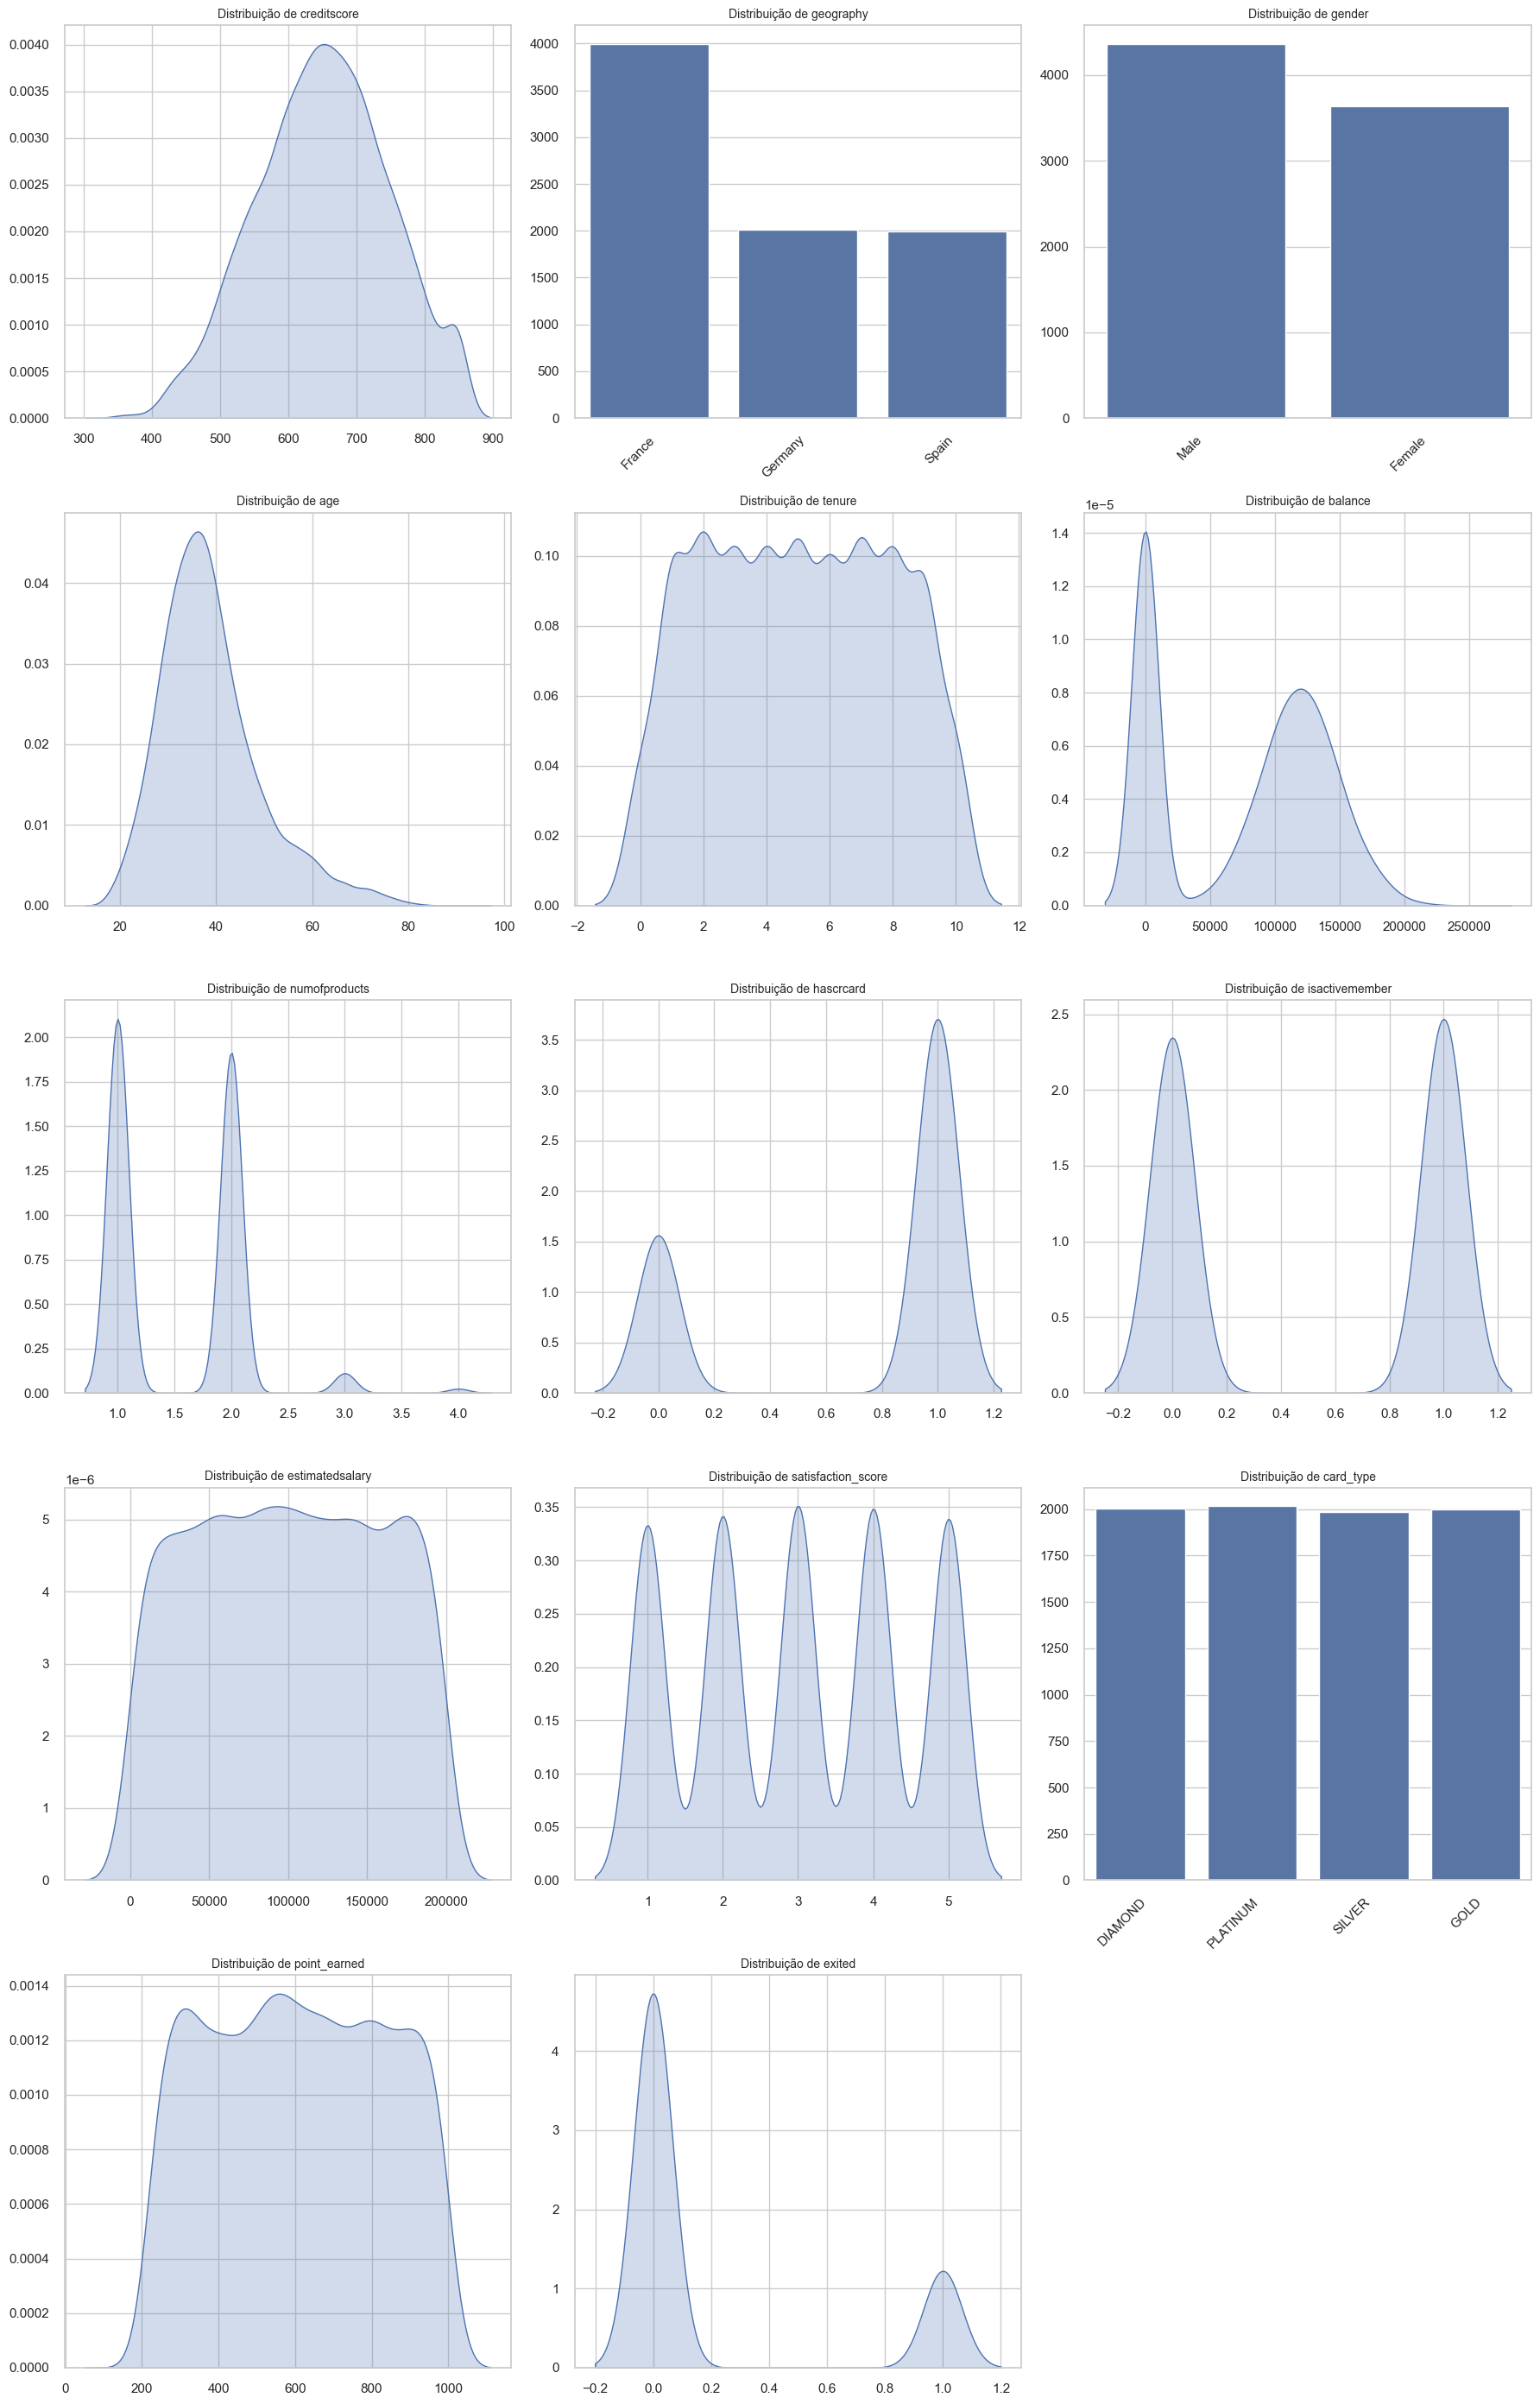

In [15]:
# Definindo o estilo de gráfico
sns.set(style="whitegrid")

# Criando uma figura grande para acomodar os subplots
fig, axes = plt.subplots(nrows=int(len(train_full.columns) / 3) + 1, ncols=3, figsize=(18, 6 * len(train_full.columns) // 3))
fig.subplots_adjust(hspace=0.5, wspace=0.5)

# Iterando sobre as colunas do DataFrame e criando um gráfico para cada
for i, col in enumerate(train_full.columns):
    ax = axes.flatten()[i]
    # Verificar se a variável é numérica ou categórica
    if train_full[col].dtype in ['int64', 'float64']:
        sns.kdeplot(train_full[col], ax=ax, fill=True)  # Usando kdeplot com preenchimento
    else:
        sns.countplot(x=col, data=train_full, ax=ax)
        plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")  # Ajusta a rotação dos labels se necessário

    ax.set_title(f'Distribuição de {col}', fontsize=10)
    ax.set_xlabel('')
    ax.set_ylabel('')

# Ajustar os gráficos que não têm dados para que não apareçam vazios
for j in range(i + 1, len(axes.flatten())):
    axes.flatten()[j].set_visible(False)

# Mostrar o gráfico
plt.tight_layout()
plt.show()

- 

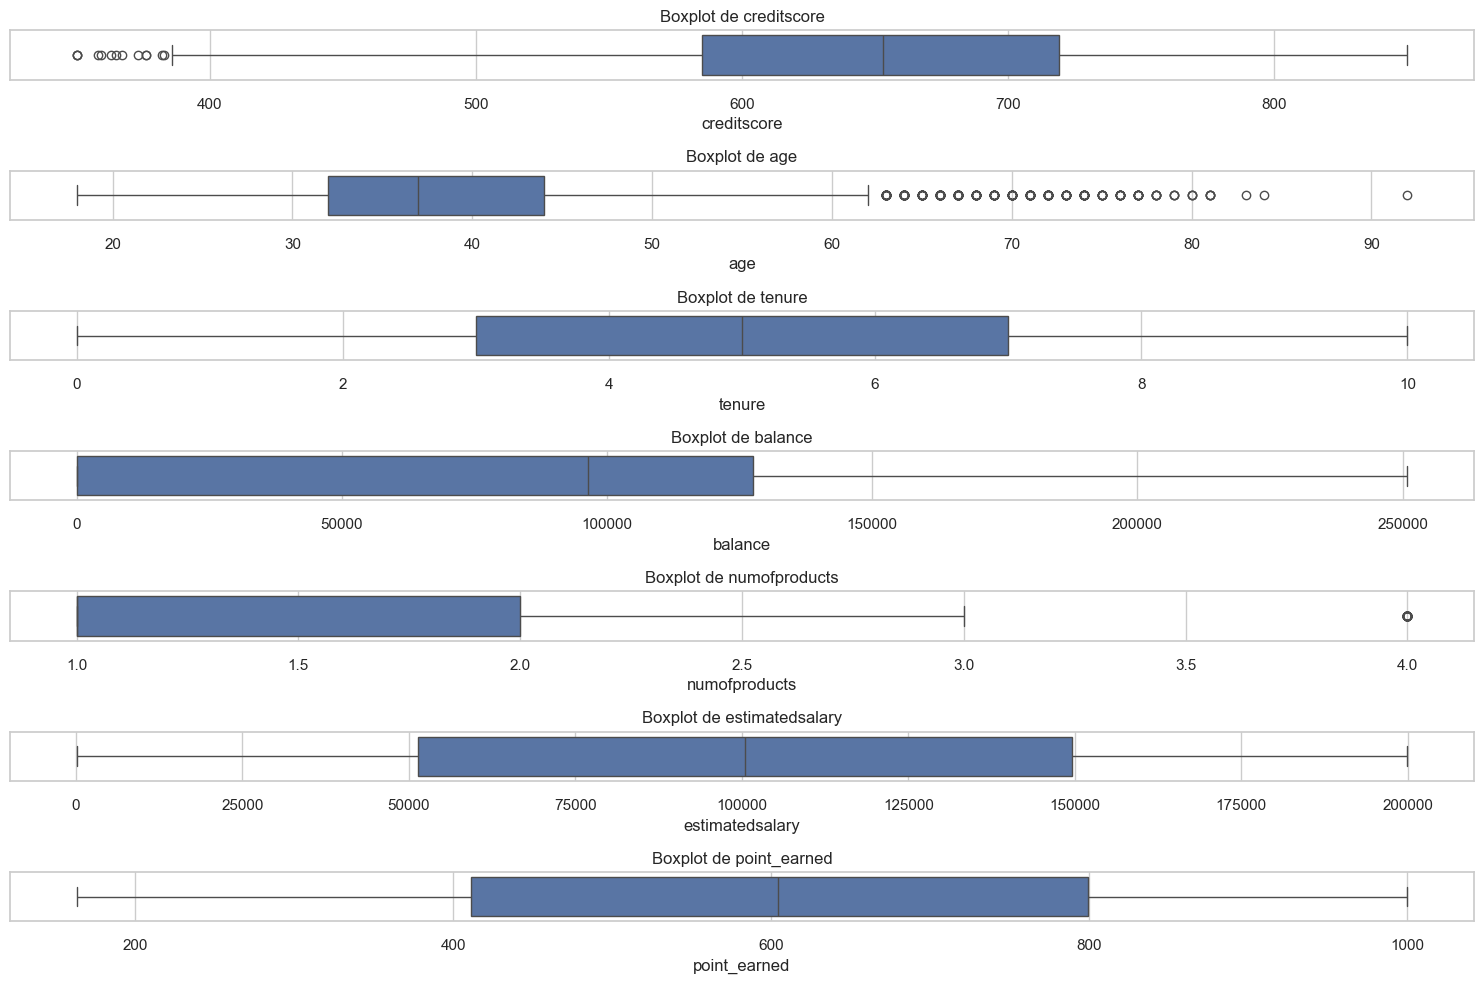

In [82]:
# Listas das categorias e variáveis numéricas, excluindo 'exited'
cate_vari = ['geography', 'gender', 'satisfaction_score', 'hascrcard', 'isactivemember', 'card_type']
num_vari = [col for col in train_full.columns if col not in (cate_vari + ['exited'])]

# Configuração do tamanho do gráfico
plt.figure(figsize=(15, 10))
for i, col in enumerate(num_vari):
    plt.subplot(len(num_vari), 1, i + 1)
    sns.boxplot(x=train_full[col])
    plt.title(f'Boxplot de {col}')
plt.tight_layout()
plt.show()

- É possível observar um concentração alta de outliers na feature idade e creditscore

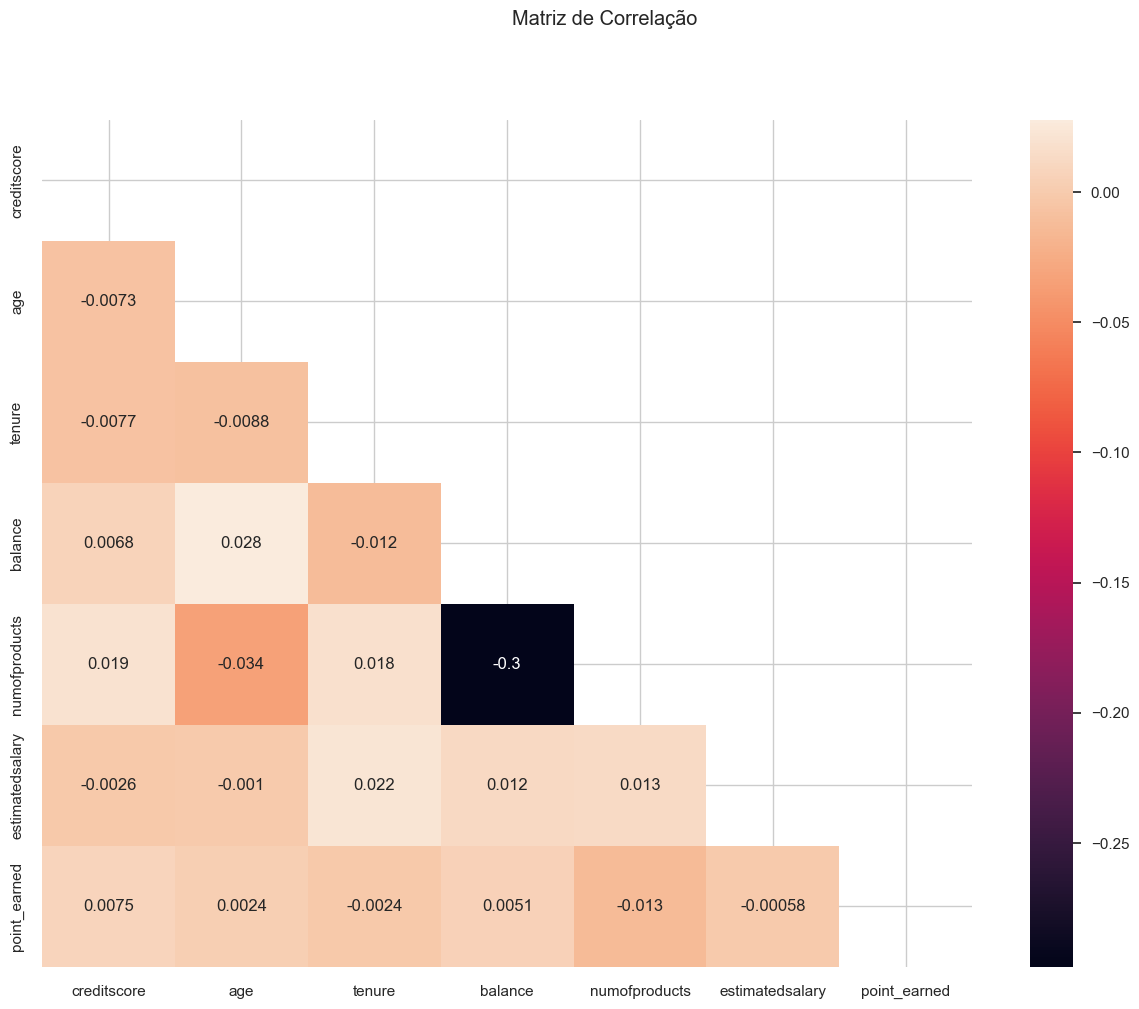

In [17]:
# Criando a Matriz de Correlação das variáveis numéricas
correlation_train = train_full[num_vari].copy().corr()

mask = np.zeros_like(correlation_train)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(15, 11))
sns.heatmap(correlation_train, mask=mask, annot=True)
plt.suptitle("Matriz de Correlação")
plt.show()

- Evidenciamos que não existe problemas de multicolinearidade entre as variáveis, nas verdades elas tem níveis de correlação de pearson muito baixos entre elas.

# 3. Preparação dos Dados

## 1- Como lidamos com dados faltantes ou outliers?
#### &ensp;&ensp; Usando discretization (creditcardscore( censoring (age)
## 2- Que passos são necessários para limpar e formatar os dados?
#### &ensp;&ensp; Será utilizados técnicas de one hot encoding e ordinal encoder 
## 3- Quais variáveis podem ser derivadas ou criadas a partir dos dados existentes?
#### &ensp;&ensp; Serão criadas mais 3 variáveis: taxa_tenure_age, log_estimated_salary e taxa_saldo_salario

In [18]:
# Separação dos dados em treino e validação para evitar data leakage
X_train, X_val, y_train, y_val = train_test_split(X_train_f, y_train_f,
                                                  test_size= 0.2, #80/20
                                                  random_state= 42)
X_train.shape, X_val.shape

((6400, 13), (1600, 13))

In [19]:
X_train.head()

creditscore geography  gender  age  tenure    balance  numofproducts  \
2579          365   Germany    Male   30       0  127760.07              1   
7128          553     Spain    Male   38       1  181110.13              2   
4082          778   Germany  Female   29       6  150358.97              1   
2550          850    France    Male   42       0       0.00              2   
4926          674   Germany  Female   36       6  100762.64              1   

      hascrcard  isactivemember  estimatedsalary  satisfaction_score  \
2579          1               0         81537.85                   4   
7128          1               0        184544.59                   4   
4082          1               0         62454.01                   4   
2550          1               0         44165.84                   2   
4926          1               0        182156.86                   3   

     card_type  point_earned  
2579   DIAMOND           342  
7128  PLATINUM           300  
4082   DIAMOND           371  
2550    SILVER           377  
4926  PLATINUM           397

Criação de Features usando pandas 

In [20]:
def transformar_features(df):
        # Razão entre o tempo de permanência (tenure) e a idade [para ponderação]
        df['taxa_tenure_age'] = df['tenure'] / df['age']
        # Transformação logarítmica do salário estimado (verifique se todos os salários são > 0 para evitar erro de log)
        df['log_estimated_salary'] = np.log(df['estimatedsalary'].clip(lower=1)) # evitando divisão por 0
        # Taxa de Saldo em relação ao salário estimado
        df['taxa_saldo_salario'] = df['balance'] / df['estimatedsalary']

        return df

In [29]:
X_train = transformar_features(X_train)
X_test = transformar_features(X_test)
X_val = transformar_features(X_val)
X_train_f = transformar_features(X_train_f)

In [22]:
feature_eng_pipe = Pipeline([
    # Lidando com outliers
    # Realizand capping de idade pela dinstancia interquartil
    ("censoring_age_out",
     Winsorizer(
         variables= ["age"],
         capping_method= "iqr", # Usando com métrica a distancia interquartil
         tail= "both",
         fold= 1.5,) # sendo pouco conservador e usando 1.5 desvio padrão
    ),
    # Separando em bins creditscore 
    ("discr_credtscore_out",
    EqualWidthDiscretiser(
         bins= 10,
         variables=["creditscore"])),
    # Encode de variáveis categóricas usando one hot encoding
    ("ohe_encoder",
     OneHotEncoder(
         top_categories= None,
         variables=["gender", "geography"],
         drop_last= False # para retorno de k variaveis dummies
     )),
    # Ordinal encoder da variável credicard_types 
    ("ordinal_encoder",
    OrdinalEncoder(encoding_method="ordered", # ordinal_enc.encoder_dict_ : {'card_type': {'GOLD': 0, 'SILVER': 1, 'PLATINUM': 2, 'DIAMOND': 3}}
                                 variables=["card_type"]))
])

In [30]:
X_train_transformed = feature_eng_pipe.fit_transform(X_train, y_train)
X_test_transformed = feature_eng_pipe.transform(X_test)
X_val_transformed = feature_eng_pipe.transform(X_val)
X_train_f_transformed = feature_eng_pipe.transform(X_train_f)

In [25]:
smote = SMOTE(
    sampling_strategy='auto',  # para ser usado apenas na classe minoritária
    k_neighbors=5
)
X_resemp, y_resemp = smote.fit_resample(X_train_transformed, y_train)

# 4. Modelagem

## Que técnicas de modelagem são apropriadas para o problema?
#### &ensp;&ensp; Modelos clássicos quando se lida com problemas de classificação tais como: Floresta aleatória, Gradiente Boosting, SVM , KNN, Árvore de decisão e regressão logistica 
## Quais são os parâmetros do modelo e como serão otimizados?
#### &ensp;&ensp;  Diversos parâmetros que podem ser visualizados junto a validação cruzada nesta sessão 
## Como avaliaremos a performance do modelo?
#### &ensp;&ensp; Primeiro avaliado o Recall e ROC curve para com otimizador do hiperparâmetros

## Baseline Model

In [33]:
# Criação de um modelo baseline de regressão logistica simples
baseline_model = LogisticRegression(max_iter=1000)
baseline_model.fit(X_train_f_transformed, y_train_f)
preds = baseline_model.predict(X_test_transformed)
print('Recall Regressão Logistica:', recall_score(y_test, preds, pos_label=1))
print('ROC-AUC Regressão Logistica:', roc_auc_score(y_test, preds))

Recall Regressão Logistica: 0.1628498727735369
ROC-AUC Regressão Logistica: 0.5636900266170111


## Validação Cruzada com teste de diferentes hiperparametros

In [36]:
# Definir os modelos e seus respectivos espaços de parâmetros reduzidos
param_grids = {
    'Logistic Regression': {
        'model': Pipeline([
            ('scaler', StandardScaler()),
            ('classifier', LogisticRegression(max_iter=2000))
        ]),
        'params': {
            'classifier__C': [0.1, 1],
            'classifier__solver': ['lbfgs', 'liblinear']
        }
    },
    'Decision Tree': {
        'model': DecisionTreeClassifier(),
        'params': {
            'max_depth': [None, 10, 20],
            'min_samples_split': [2, 5]
        }
    },
    'KNN': {
        'model': Pipeline([
            ('scaler', StandardScaler()),
            ('classifier', KNeighborsClassifier())
        ]),
        'params': {
            'classifier__n_neighbors': [3, 5],
            'classifier__weights': ['uniform', 'distance']
        }
    },
    'Random Forest': {
        'model': RandomForestClassifier(),
        'params': {
            'n_estimators': [50, 100],
            'max_features': ['auto', 'sqrt'],
            'max_depth': [None, 10, 20],
            'min_samples_split': [2, 5]
        }
    },
    'GBM': {
        'model': GradientBoostingClassifier(),
        'params': {
            'n_estimators': [50, 100],
            'learning_rate': [0.1, 0.2],
            'max_depth': [3, 5]
        }
    },
    'SVM': {
        'model': Pipeline([
            ('scaler', StandardScaler()),
            ('classifier', SVC(probability=True))
        ]),
        'params': {
            'classifier__C': [0.1, 1],
            'classifier__kernel': ['linear', 'rbf']
        }
    }
}

X = X_resemp
y = y_resemp
X_val = X_val_transformed 

# Dicionário para armazenar os resultados
best_models_roc_auc = {}
best_models_recall = {}

# Realizar o GridSearchCV para cada modelo com scoring roc_auc
print("Performing GridSearchCV with ROC AUC scoring...")
for model_name, mp in param_grids.items():
    clf = GridSearchCV(mp['model'], mp['params'], cv=5, scoring='roc_auc')
    clf.fit(X, y)
    best_models_roc_auc[model_name] = clf.best_estimator_
    print(f"{model_name} (ROC AUC): Best Parameters: {clf.best_params_}, Best Score: {clf.best_score_:.2f}")

# Realizar o GridSearchCV para cada modelo com scoring recall
print("\nPerforming GridSearchCV with Recall scoring...")
for model_name, mp in param_grids.items():
    clf = GridSearchCV(mp['model'], mp['params'], cv=5, scoring='recall')
    clf.fit(X, y)
    best_models_recall[model_name] = clf.best_estimator_
    print(f"{model_name} (Recall): Best Parameters: {clf.best_params_}, Best Score: {clf.best_score_:.2f}")

# Avaliar os melhores modelos nos dados de validação
print("\nEvaluating best models on validation data:")
for model_name in param_grids.keys():
    print(f"\n{model_name}:")

    # Avaliar ROC AUC
    model_roc_auc = best_models_roc_auc[model_name]
    y_val_pred_proba_roc_auc = model_roc_auc.predict_proba(X_val)[:, 1]
    roc_auc = roc_auc_score(y_val, y_val_pred_proba_roc_auc)
    print(f"  ROC AUC on validation data: {roc_auc:.2f}")

    # Avaliar Recall
    model_recall = best_models_recall[model_name]
    y_val_pred_recall = model_recall.predict(X_val)
    recall = recall_score(y_val, y_val_pred_recall)
    print(f"  Recall on validation data: {recall:.2f}")

Performing GridSearchCV with ROC AUC scoring...
Logistic Regression (ROC AUC): Best Parameters: {'classifier__C': 0.1, 'classifier__solver': 'liblinear'}, Best Score: 0.91
Decision Tree (ROC AUC): Best Parameters: {'max_depth': 10, 'min_samples_split': 5}, Best Score: 0.88
KNN (ROC AUC): Best Parameters: {'classifier__n_neighbors': 5, 'classifier__weights': 'distance'}, Best Score: 0.93
Random Forest (ROC AUC): Best Parameters: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 100}, Best Score: 0.96
GBM (ROC AUC): Best Parameters: {'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 100}, Best Score: 0.95
SVM (ROC AUC): Best Parameters: {'classifier__C': 1, 'classifier__kernel': 'rbf'}, Best Score: 0.94

Performing GridSearchCV with Recall scoring...
Logistic Regression (Recall): Best Parameters: {'classifier__C': 0.1, 'classifier__solver': 'lbfgs'}, Best Score: 0.76
Decision Tree (Recall): Best Parameters: {'max_depth': 20, 'min_samples_split': 2}, Be

### É possível evidenciar um alto nível de overfitting no modelo

In [61]:
best_rf_model = RandomForestClassifier(max_depth= None, max_features= 'sqrt', min_samples_split= 2, n_estimators= 100)
best_gbm_model = GradientBoostingClassifier(learning_rate= 0.2, max_depth= 5, n_estimators= 100)
best_rf_model.fit(X_resemp,y_resemp)
best_gbm_model.fit(X_resemp,y_resemp)

GradientBoostingClassifier(learning_rate=0.2, max_depth=5)

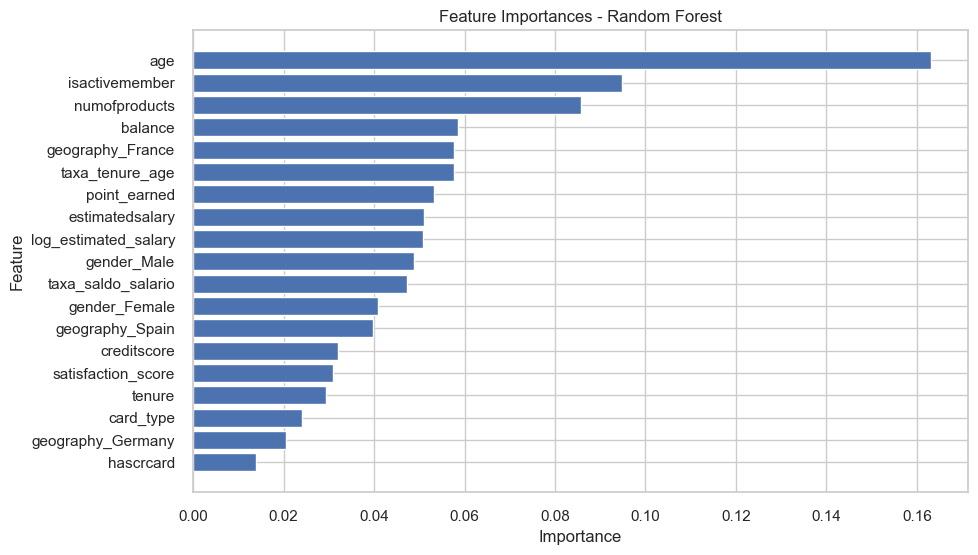

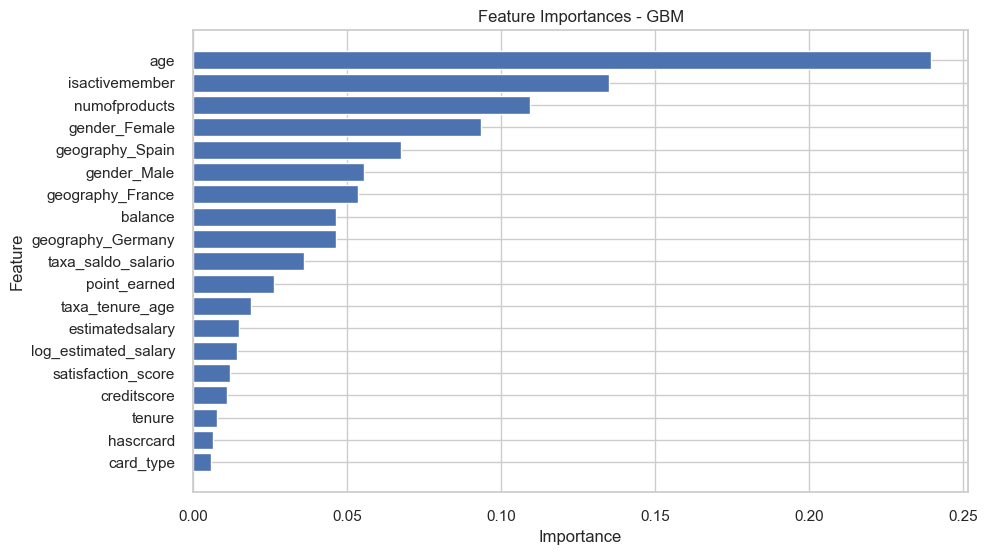

In [62]:
# Importância das features do Random Forest
rf_feature_importances = best_rf_model.feature_importances_
rf_features = X.columns  

rf_importances_df = pd.DataFrame({'Feature': rf_features, 'Importance': rf_feature_importances})
rf_importances_df = rf_importances_df.sort_values(by='Importance', ascending=False)

# Plotando a importância das features do Random Forest
plt.figure(figsize=(10, 6))
plt.barh(rf_importances_df['Feature'], rf_importances_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances - Random Forest')
plt.gca().invert_yaxis()
plt.show()

# Importância das features do GBM
gbm_feature_importances = best_gbm_model.feature_importances_
gbm_features = X.columns  # Ajuste se X for um DataFrame

gbm_importances_df = pd.DataFrame({'Feature': gbm_features, 'Importance': gbm_feature_importances})
gbm_importances_df = gbm_importances_df.sort_values(by='Importance', ascending=False)

# Plotando a importância das features do GBM
plt.figure(figsize=(10, 6))
plt.barh(gbm_importances_df['Feature'], gbm_importances_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances - GBM')
plt.gca().invert_yaxis()
plt.show()

# 5. Avaliação

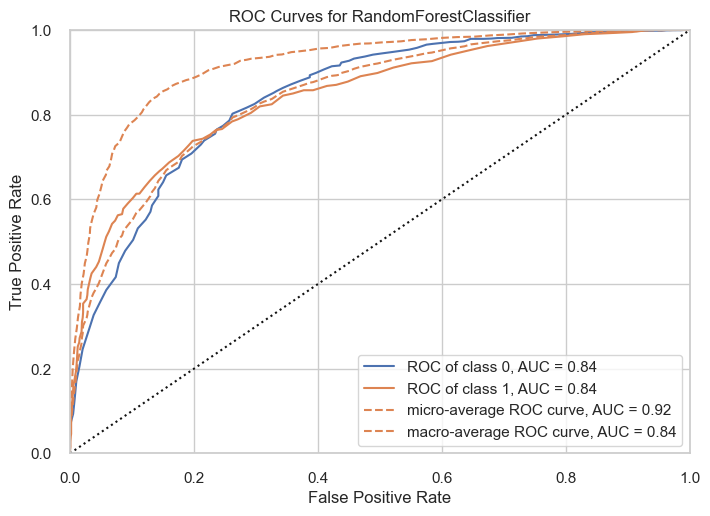

<Axes: title={'center': 'ROC Curves for RandomForestClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [63]:
visualizer = ROCAUC(best_rf_model, classes=[0, 1])

visualizer.fit(X_resemp, y_resemp)     
visualizer.score(X_test_transformed, y_test)       
visualizer.show()        

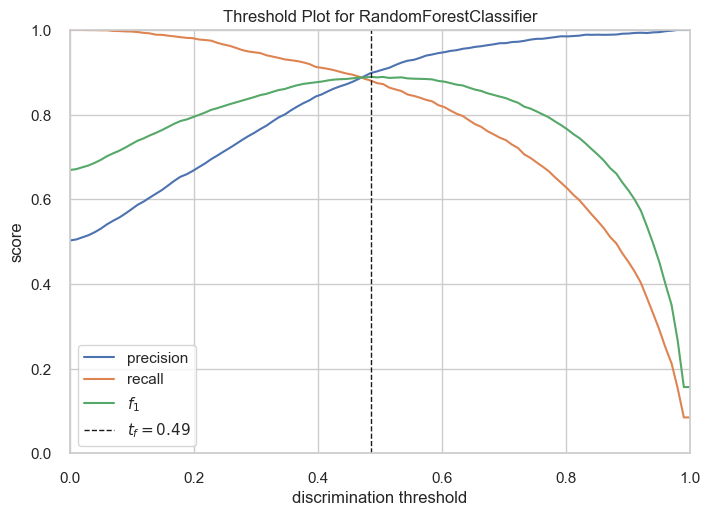

<Axes: title={'center': 'Threshold Plot for RandomForestClassifier'}, xlabel='discrimination threshold', ylabel='score'>

In [70]:
visualizer = DiscriminationThreshold(best_rf_model,
                                     n_trials=1,
                                     cv=0.5,
                                     argmax='fscore',
                                     random_state=0,
                                     is_fitted='auto',
                                     exclude = "queue_rate")
visualizer.fit(X_resemp, y_resemp)       
visualizer.score(X_test_transformed, y_test)      
visualizer.show()      

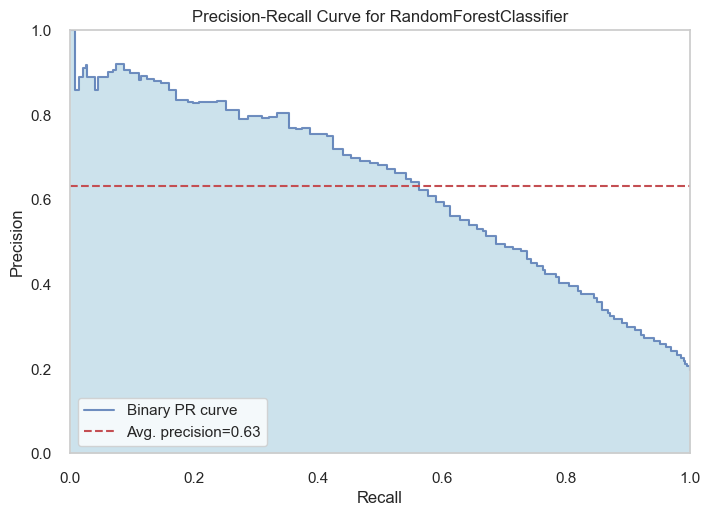

<Axes: title={'center': 'Precision-Recall Curve for RandomForestClassifier'}, xlabel='Recall', ylabel='Precision'>

In [72]:
visualizer = PrecisionRecallCurve(best_rf_model, classes=[0, 1])

visualizer.fit(X_resemp, y_resemp)       
visualizer.score(X_test_transformed, y_test)        
visualizer.show()   

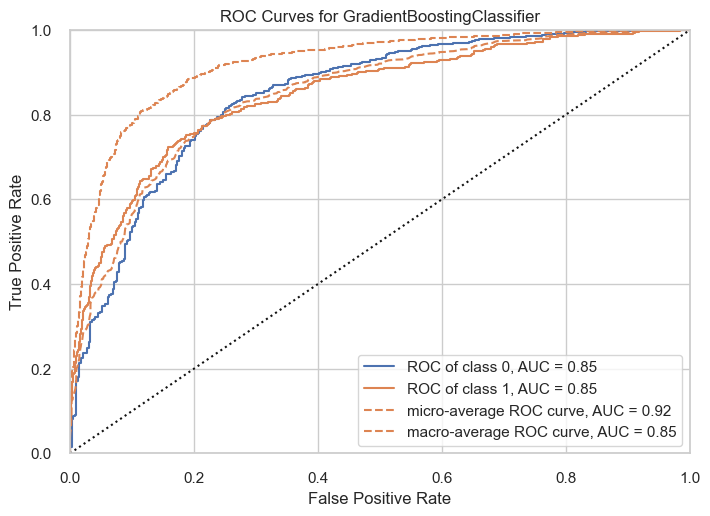

<Axes: title={'center': 'ROC Curves for GradientBoostingClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [68]:
visualizer = ROCAUC(best_gbm_model, classes=[0, 1])

visualizer.fit(X_resemp, y_resemp)        # Fit the training data to the visualizer
visualizer.score(X_test_transformed, y_test)        # Evaluate the model on the test data
visualizer.show()        # Finalize and show the figure

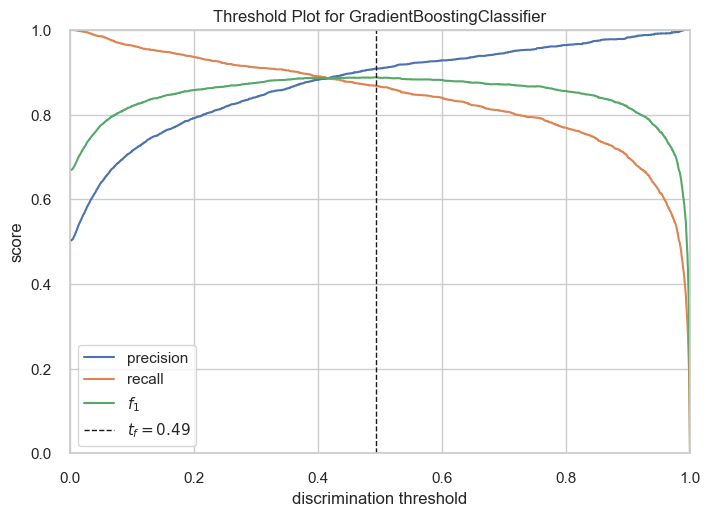

<Axes: title={'center': 'Threshold Plot for GradientBoostingClassifier'}, xlabel='discrimination threshold', ylabel='score'>

In [71]:
visualizer = DiscriminationThreshold(best_gbm_model,
                                     n_trials=1,
                                     cv=0.5,
                                     argmax='fscore',
                                     random_state=0,
                                     is_fitted='auto',
                                     exclude = "queue_rate")
visualizer.fit(X_resemp, y_resemp)        # Fit the training data to the visualizer
visualizer.score(X_test_transformed, y_test)        # Evaluate the model on the test data
visualizer.show()        # Finalize and show the figure

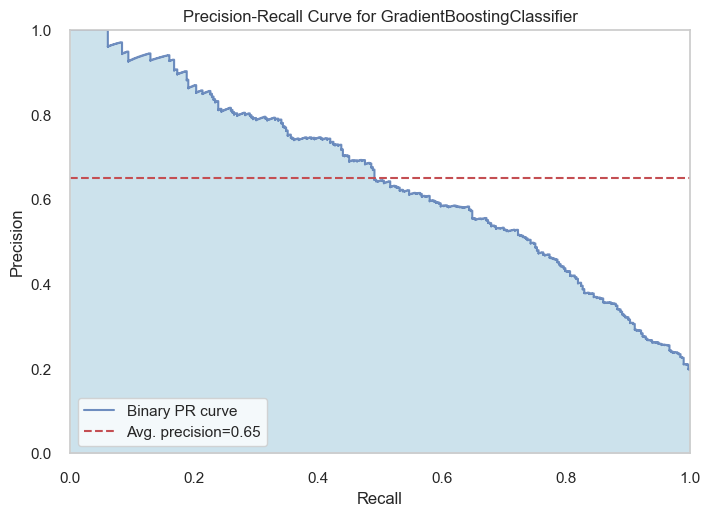

<Axes: title={'center': 'Precision-Recall Curve for GradientBoostingClassifier'}, xlabel='Recall', ylabel='Precision'>

In [73]:
visualizer = PrecisionRecallCurve(best_gbm_model, classes=[0, 1])

visualizer.fit(X_resemp, y_resemp)        # Fit the training data to the visualizer
visualizer.score(X_test_transformed, y_test)        # Evaluate the model on the test data
visualizer.show()        # Finalize and show the figure

## O modelo atende aos objetivos de negócio?
#### &ensp;&ensp;  Atende os objetivos ao superar bastante o modelo baseline nas métricas estipuladas
## Existem áreas onde o modelo poderia ser melhorado?
#### &ensp;&ensp;  Expansão os hiperparâmetros,  seleção de outros modelos para testagem e verificação comparativa da eficiência do método SMOTE (ou suas variações) 
## Como o modelo se comporta em diferentes segmentos dos dados?
#### &ensp;&ensp;  Além dos dados de teste também foram utilizados dados de validação para testar os hiperparâmetros, logo o resultado apresentado de... se mostra consistente 
## Quais são as implicações de negócios dos resultados do modelo?
#### &ensp;&ensp; Isso varia muito a métrica escolhida de Precision-Recall e ROC curve servem para estipular o melhor modelo, em uma perspectiva de churn, a escolha entre que ponto é melhor para otimização do Trade-of precision/recall depende dos custo operacionais do negócio.
#### &ensp;&ensp; Caso um falso positivo custasse muito a empresa (por exemplo, altos gastos como ads pagos direcionados, taxas de descontos para produtos/investimentos e alta demanda de tempo dos colaborados) um foco maior no recall pode ser benéfico, garantindo que menos clientes reais sejam perdidos. Por outro lado, se a falha em prever a saída de um cliente resulta em perdas maiores (como investimentos perdidos ou oportunidades de venda perdidas), então um modelo com maior precision pode ser preferível, minimizando as intervenções desnecessárias e os custos associados.